# **House Price Prediction with Linear Regression and Random Forest**

The aim of this project is to predict real-estate prices using the machine learning algorithm, Linear Regression, Random Forest. Both will show different results for the accuracy. Also, I will use regression with regularization - Ridge and Lasso to try to improve the prediction accuracy.

# **Imports**

In [39]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from datetime import datetime
import io
import mpl_toolkits
import numpy as np
%matplotlib inline


In [40]:
# Load the data
local_file = files.upload()
train_data = io.BytesIO(local_file['data.csv'])
df = pd.read_csv(train_data)


Saving data.csv to data (3).csv


# **Preparing the data for training the models**

**Train-Test Split dataset**


 Necessary imports

In [41]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   90 non-null     int64  
 1   TYPE         90 non-null     float64
 2   STREET NAME  90 non-null     object 
 3   POSTCODE     90 non-null     int64  
 4   LIVING_AREA  90 non-null     float64
 5   ROOMS        90 non-null     float64
 6   LogOfPrice   90 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 5.0+ KB


In [43]:
df.isnull().sum()

Unnamed: 0     0
TYPE           0
STREET NAME    0
POSTCODE       0
LIVING_AREA    0
ROOMS          0
LogOfPrice     0
dtype: int64

Analyzing the numeric features.


In [44]:
numeric_features = df.select_dtypes(include=[np.number])

In [45]:
numeric_features.columns

Index(['Unnamed: 0', 'TYPE', 'POSTCODE', 'LIVING_AREA', 'ROOMS', 'LogOfPrice'], dtype='object')

In [46]:
# set the target and predictors
y = df.LogOfPrice  # target

# use only those input features with numeric data type 
df_temp = df.select_dtypes(include=["int64","float64"]) 

X = df_temp.drop(["LogOfPrice"],axis=1)  # predictors

To split the dataset, I will use random sampling with 80/20 train-test split; that is, 80% of the dataset will be used for training and set aside 20% for testing:

In [47]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# **Modelling**

Two models will be built and evaluated by their performances with R-squared metric. Additionally, insights on the features that are strong predictors of house prices, will be analised .

**Linear Regression**



To fit a linear regression model, the features which have a high correlation with the target variable PRICE are selected. By looking at the correlation matrix, it is noticable that the rooms and the living area have a strong correlation with the price ('Log of price').

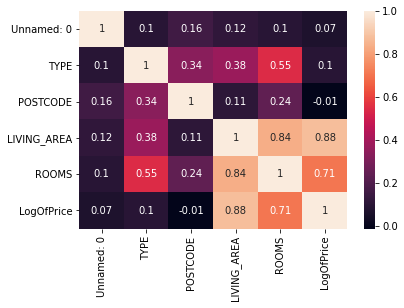

In [48]:
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [49]:
lr = LinearRegression()
# fit optimal linear regression line on training data
lr.fit((X_train),y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.
>RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. In this case, it is exactly 0.2, so it is relatively accurate.

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
# model evaluation for training set
y_train_predict = lr.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))

print("The model performance for training set:")
print('RMSE is {}'.format(rmse))

The model performance for training set:
RMSE is 0.18718490357046388


In [52]:
# model evaluation for testing set
y_test_predict = lr.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
print("The model performance for testing set:")
print('RMSE is {}'.format(rmse))

The model performance for testing set:
RMSE is 0.17043916305634482


In [53]:
#predict y_values using X_test set
yr_hat = lr.predict(X_test)

In [54]:
lr_score =lr.score((X_test),y_test)
print("Accuracy: ", lr_score)

Accuracy:  0.8313559528055092


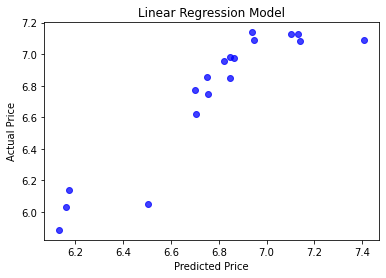

In [55]:
actual_values = y_test
plt.scatter(yr_hat, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()
#pltrandom_state=None.show()

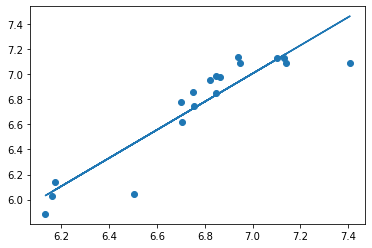

In [56]:
from scipy import stats

#Execute a method that returns the important key values of Linear Regression
slope, intercept, r, p, std_err = stats.linregress(yr_hat, y_test)
#Create a function that uses the slope and intercept values to return a new value. This new value represents where on the y-axis the corresponding x value will be placed
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, yr_hat))
#Draw the scatter plot
plt.scatter(yr_hat, y_test)
#Draw the line of linear regression
plt.plot(yr_hat, mymodel)
plt.show()

Using cross-validation to see whether the model is over-fitting the data.

In [57]:
# cross validation to find 'validate' score across multiple samples, automatically does Kfold stratifying
lr_cv = cross_val_score(lr, X, y, cv = 5, scoring= 'r2')
print("Cross-validation results: ", lr_cv)
print("R2: ", lr_cv.mean())

Cross-validation results:  [0.83209799 0.85952326 0.78676919 0.86128568 0.01236206]
R2:  0.6704076358454658


>It doesn't appear that for this train-test dataset the model is  over-fitting the data (the cross-validation performance is very close in value). 

**Regularization:**


The alpha parameter in ridge and lasso regularizes the regression model. The regression algorithms with regularization differ from linear regression in that they try to penalize those features that are not significant in our prediction. Ridge will try to reduce their effects (i.e., shrink their coeffients) in order to optimize all the input features. Lasso will try to remove the not-significant features by making their coefficients zero. In short, Lasso (L1 regularization) can eliminate the not-significant features, thus performing feature selection while Ridge (L2 regularization) cannot.

**Lasso regression**

In [58]:
lasso = Lasso(alpha = 1)  # sets alpha to almost zero as baseline
lasso.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

RMSE tells you how concentrated the data is around the line of best fit. 

In [59]:
# model evaluation for training set
y_train_l_predict = lasso.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_l_predict)))

print("The model performance for training set:")
print('RMSE is {}'.format(rmse))

The model performance for training set:
RMSE is 0.21704469540917606


> RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. In this case, it is 0.5, so it is relatively accurate.

In [60]:
# model evaluation for testing set
y_test_l_predict = lasso.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_l_predict)))
print("The model performance for testing set:")
print('RMSE is {}'.format(rmse))

The model performance for testing set:
RMSE is 0.244204476549742


> RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. In this case, it is 0.5, so it is relatively accurate.

In [61]:
#predict y_values using X_test set
yr_lasso = lasso.predict(X_test)

In [62]:
lasso_score =lasso.score((X_test),y_test)
print("Accuracy: ", lasso_score)

Accuracy:  0.6537901085524149


In [63]:
lasso_cv = cross_val_score(lasso, X, y, cv = 5, scoring = 'r2')
print ("Cross-validation results: ", lasso_cv)
print ("R2: ", lasso_cv.mean())

Cross-validation results:  [ 0.86105682  0.81158329  0.66015413  0.89623048 -0.28606503]
R2:  0.5885919367555781


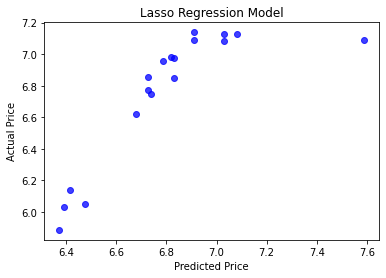

In [64]:
actual_values = y_test
plt.scatter(yr_lasso, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Lasso Regression Model')
plt.show()
#pltrandom_state=None.show()

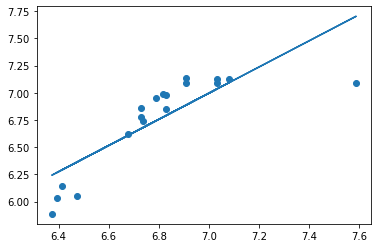

In [65]:
from scipy import stats

#Execute a method that returns the important key values of Linear Regression
slope, intercept, r, p, std_err = stats.linregress(yr_lasso, y_test)
#Create a function that uses the slope and intercept values to return a new value. This new value represents where on the y-axis the corresponding x value will be placed
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, yr_lasso))
#Draw the scatter plot
plt.scatter(yr_lasso, y_test)
#Draw the line of linear regression
plt.plot(yr_lasso, mymodel)
plt.show()

**Ridge regression**

In [66]:
ridge = Ridge(alpha = 1)  # sets alpha to a default value as baseline  
ridge.fit(X_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [67]:
# model evaluation for training set
y_train_r_predict = ridge.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_r_predict)))

print("The model performance for training set:")
print('RMSE is {}'.format(rmse))

The model performance for training set:
RMSE is 0.18726114726985654


>RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. In this case, it is 0.2, so it is relatively accurate.

In [68]:
# model evaluation for testing set
y_test_r_predict = ridge.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_r_predict)))
print("The model performance for testing set:")
print('RMSE is {}'.format(rmse))

The model performance for testing set:
RMSE is 0.17243264721239707


>RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. In this case, it is rounded to 0.2, so it is relatively accurate.

In [69]:
#predict y_values using X_test set
yr_ridge = ridge.predict(X_test)

In [70]:
ridge_score =ridge.score((X_test),y_test)
print("Accuracy: ", ridge_score)

Accuracy:  0.8273879058847499


In [71]:
ridge_cv = cross_val_score(ridge, X, y, cv = 5, scoring = 'r2')
print ("Cross-validation results: ", ridge_cv)
print ("R2: ", ridge_cv.mean())

Cross-validation results:  [0.83870961 0.85893948 0.78384719 0.86257048 0.00911816]
R2:  0.6706369828239415


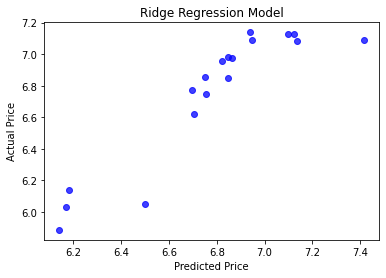

In [72]:
actual_values = y_test
plt.scatter(yr_ridge, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regression Model')
plt.show()
#pltrandom_state=None.show()

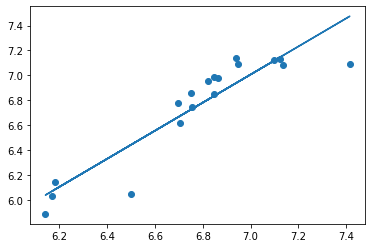

In [73]:
from scipy import stats

#Execute a method that returns the important key values of Linear Regression
slope, intercept, r, p, std_err = stats.linregress(yr_ridge, y_test)
#Create a function that uses the slope and intercept values to return a new value. This new value represents where on the y-axis the corresponding x value will be placed
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, yr_ridge))
#Draw the scatter plot
plt.scatter(yr_ridge, y_test)
#Draw the line of linear regression
plt.plot(yr_ridge, mymodel)
plt.show()

**Random Forest**

The library sklearn.ensemble is used to solve regression problems via Random forest. The most important parameter is the n_estimators parameter. This parameter defines the number of trees in the random forest.

In [74]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [75]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

Evaluating the Algorithm:
The last and final step of solving a machine learning problem is to evaluate the performance of the algorithm. For regression problems the metrics used to evaluate an algorithm are mean absolute error, mean squared error, and root mean squared error.

In [76]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.10685031703790503
Mean Squared Error: 0.021000237058994915
Root Mean Squared Error: 0.14491458539082572


Training the model

In [77]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Making predictions on the test set:

When performing regression, the absolute error should be used.It needs to be checked how far away the average prediction is from the actual value so the absolute value has to be calculated.

In [78]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.11 degrees.




> There is a 0.11 improvement.



Determine performance metrics:

To put the predictions in perspective, accuracy can be calculated by using the mean average percentage error subtracted from 100 %.

In [79]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors /y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 98.38 %.


> The model has learned how to predict the price with 98% accuracy.

In [80]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train) # gets the parameters for the rfr model
rfr_cv = cross_val_score(rfr,X, y, cv = 5, scoring = 'r2')
print("R2: ", rfr_cv.mean())

R2:  0.6364866731455432


The performance of Random forest is slightly better than the Linear regression. The model parameters can be optimised for better performance using gridsearch.

In [81]:
#Random forest determined feature importances
rfr.feature_importances_

array([0.0432824 , 0.02518928, 0.04192148, 0.85429658, 0.03531027])

# **Plotting the Feature Importance**

Finding the features that are the most promissing predictors:

In [82]:
importance = rfr.feature_importances_

# map feature importance values to the features
feature_importances = zip(importance, X.columns)

#list(feature_importances)
sorted_feature_importances = sorted(feature_importances, reverse = True)

#print(sorted_feature_importances)
top_15_predictors = sorted_feature_importances[0:15]
values = [value for value, predictors in top_15_predictors]
predictors = [predictors for value, predictors in top_15_predictors]
print(predictors)

['LIVING_AREA', 'Unnamed: 0', 'POSTCODE', 'ROOMS', 'TYPE']


**Plotting the feauture importance of the Random forest.**

Plotting the feature importances to illustrate the disparities in the relative significance of the variables. 

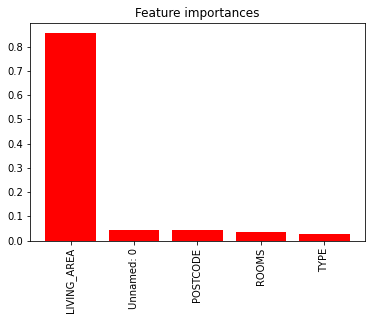

In [83]:
plt.figure()
plt.title( "Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

The idea behind the plotting of feauture importance is that after evaluating the performance of the model, the values of a feature of interest must be permuted and reevaluate model performance.
The feature importance (variable importance) describes which features are relevant. 
>Random Forest determined that overall the living area of a home is by far the most important predictor. Following are the sizes of above rooms and postcode.

# **Conclusion**

I used four models to determine the accuracy - Linear Regression, Lasso Regression and Ridge Regression, Random Forest.

From the exploring of the models RMSE:

* Linear Regression score: 0.2003 (0.1887)

* Lasso score: 0.5 (0.4675)

* Ridge score: 0.2 (0.1877)

* Random forest score: 0.2372 

> RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. All of the models showed values in this range.

From the exploring of the models accuracy: 

* Linear Regression score:  0.80 (80%)

* Lasso score: 0.82 (82%)

* Ridge score: 0.86 (86%)

* Random forest score: 98.13 %

From the exploring of the models cross-validation:  

* Linear Regression score:  R2: 0.7308604883584712

* Lasso score: R2:  0.6532616143265344

* Ridge score: R2:  0.7310756447849953

* Random forest: R2:  0.7742740242196954

Random forest turns out to be the more accurate model for predicting the house price. 

All of the models showed RMSE values between 0.2 and 0.5 so that they show  relatively accurate predictions of the data. 

I evaluated the models performances with R-squared metric and the one that is overfitting the least is the Linear Regression.

